# Network Analysis Lab

Complete the following exercises to help solidify your understanding of network analysis.

In [ ]:
!pip install nxviz

In [ ]:
!pip install -U pandas-profiling

In [ ]:
!pip install community

In [36]:
import networkx as nx
import nxviz
import community
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms import community

In [48]:
plt.rcParams['figure.figsize'] = (12,8)

## U.S. Mens Basketball Data Set

In the `us_mens_basketball.csv` data set, each row represents an single basketball player's participation in a single event at a single Olympics. 

In [ ]:
from google.colab import files
uploaded = files.upload()

In [2]:
basketball = pd.read_csv('us_mens_basketball.csv')

In [3]:
basketball.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,351,Julius Shareef Abdur-Rahim,M,23.0,202.0,104.0,United States,USA,2000 Summer,2000,Summer,Sydney,Basketball,Basketball Men's Basketball,Gold
1,2636,"Stephen Todd ""Steve"" Alford",M,19.0,185.0,74.0,United States,USA,1984 Summer,1984,Summer,Los Angeles,Basketball,Basketball Men's Basketball,Gold
2,2863,Walter Ray Allen,M,25.0,192.0,93.0,United States,USA,2000 Summer,2000,Summer,Sydney,Basketball,Basketball Men's Basketball,Gold
3,3874,"William Lloyd ""Willie"" Anderson, Jr.",M,21.0,200.0,86.0,United States,USA,1988 Summer,1988,Summer,Seoul,Basketball,Basketball Men's Basketball,Bronze
4,4505,Carmelo Kyan Anthony,M,20.0,203.0,109.0,United States,USA,2004 Summer,2004,Summer,Athina,Basketball,Basketball Men's Basketball,Bronze


## 1. Transform this data set into one that can be turned into a graph where the entities are represented by the Name field and the relationships are represented by whether the players played in the same Olympics together (Games field).

Sort descending by the number of pairwise interactions. Which pair of players have competed in the most Olympics together?

In [4]:
def df_to_graph(df, entity, edge):
    df2 = df.copy()
    graph_df = pd.merge(df, df2, how='inner', on=edge)
    graph_df = graph_df.groupby([entity + '_x', entity + '_y']).count().reset_index()
    graph_df = graph_df[graph_df[entity + '_x'] != graph_df[entity + '_y']]
    
    if type(edge) == list:
        graph_df = graph_df[[entity + '_x', entity + '_y'] + edge]
    else:
        graph_df = graph_df[[entity + '_x', entity + '_y', edge]]
    
    return graph_df

In [5]:
graph = df_to_graph(basketball, 'Name', 'Games')

In [14]:
graph.head()

,Name_x,Name_y,Games
1,Adrian Delano Dantley,"Ernest ""Ernie"" Grunfeld",1
2,Adrian Delano Dantley,"Kenneth Alan ""Kenny"" Carr",1
3,Adrian Delano Dantley,"Michel Taylor ""Tate"" Armstrong",1
4,Adrian Delano Dantley,"Mitchell William ""Mitch"" Kupchak",1
5,Adrian Delano Dantley,"Philip Jackson ""Phil"" Ford, Jr.",1


## 2. Use the `from_pandas_edgelist` method to turn the data frame into a graph.

In [6]:
from networkx.convert_matrix import from_pandas_edgelist

In [15]:
B = nx.from_pandas_edgelist(graph, source='Name_x', target='Name_y', edge_attr=True)

## 3. Compute and print the following graph statistics for the graph:

- Number of nodes
- Number of edges
- Average degree
- Density

In [17]:
B.order()
# number of nodes

196

In [18]:
B.size()
# number of edges

1232

In [26]:
np.mean(list(dict(nx.degree(B)).values()))
# average degree

12.571428571428571

In [19]:
nx.density(B)
# density

0.06446886446886448

## 4. Compute betweenness centrality for the graph and print the top 5 nodes with the highest centrality.

In [31]:
pd.DataFrame.from_dict(nx.betweenness_centrality(B), orient='index').reset_index().sort_values(0, ascending=False).head()

,index,0
41,Gary Dwayne Payton,0.091938
42,Jason Frederick Kidd,0.091356
53,Carmelo Kyan Anthony,0.047423
86,David Maurice Robinson,0.032662
119,"William Marion ""Bill"" Hougland",0.030241


## 5. Compute Eigenvector centrality for the graph and print the top 5 nodes with the highest centrality.

In [33]:
pd.DataFrame.from_dict(nx.eigenvector_centrality_numpy(B), orient='index').reset_index().sort_values(0, ascending=False).head()

,index,0
53,Carmelo Kyan Anthony,0.341850
57,LeBron Raymone James,0.288454
81,Kobe Bean Bryant,0.224317
76,"Christopher Emmanuel ""Chris"" Paul",0.224317
77,Deron Michael Williams,0.224317


## 6. Compute degree centrality for the graph and print the top 5 nodes with the highest centrality.

In [34]:
pd.DataFrame.from_dict(nx.degree_centrality(B), orient='index').reset_index().sort_values(0, ascending=False).head()

,index,0
53,Carmelo Kyan Anthony,0.184615
86,David Maurice Robinson,0.143590
33,"Robert Albert ""Bob"" Kurland",0.133333
57,LeBron Raymone James,0.133333
119,"William Marion ""Bill"" Hougland",0.123077


## 7. Generate a network visualization for the entire graph using a Kamada-Kawai force-directed layout.

In [40]:
plt.rcParams['figure.figsize'] = (8,15)

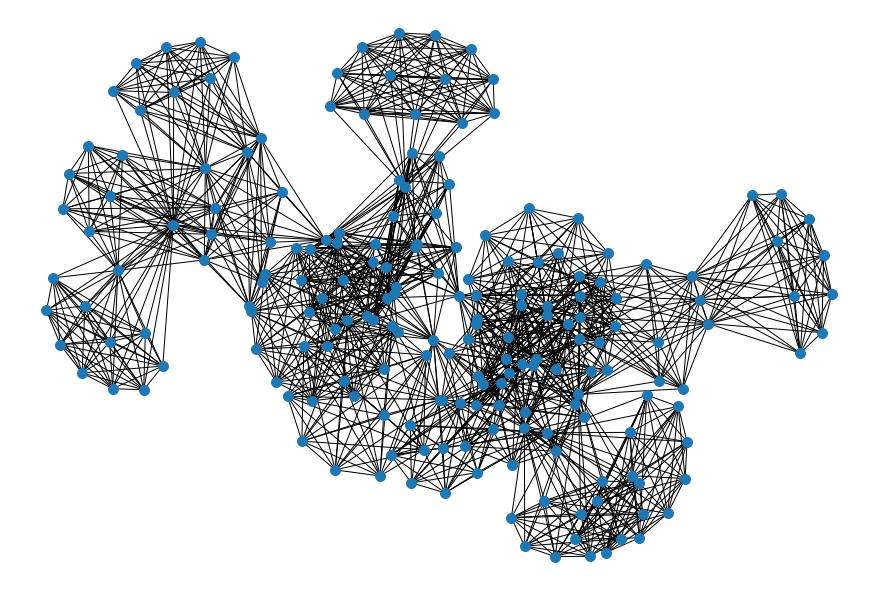

In [50]:
nx.draw(B, pos=nx.kamada_kawai_layout(B), node_size=100)

## 8. Create and visualize an ego graph for the player with the highest betweenness centrality.

## 9. Identify the communities within the entire graph and produce another visualization of it with the nodes color-coded by the community they belong to.

In [43]:
import community as louvain

In [46]:
communities = list(louvain.best_partition(B).values())

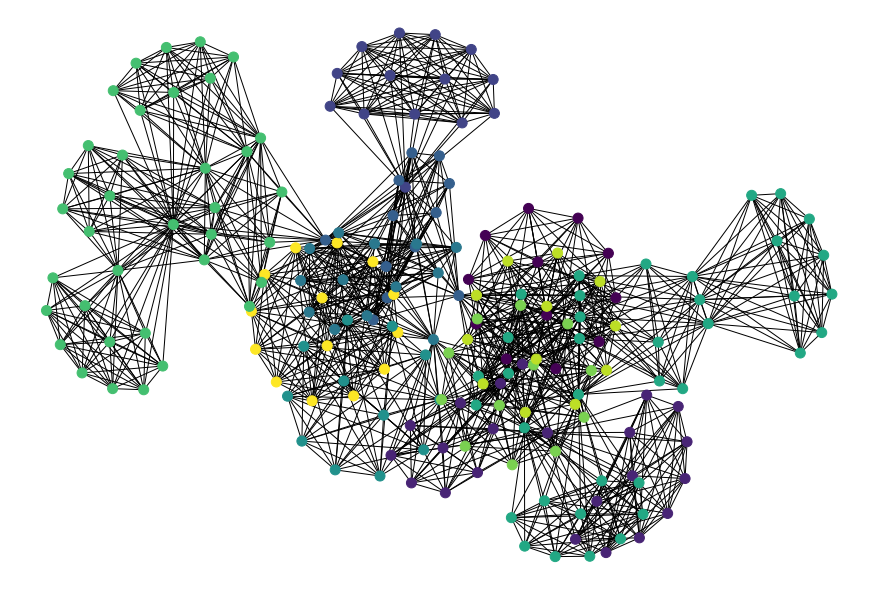

In [56]:
nx.draw_kamada_kawai(B, node_size = 100, node_color = communities)

## Bonus: Hierarchical Graphs

Thus far, we have analyzed graphs where the nodes represented individual players and the edges represented Olympic games that they have competed in together. We can analyze the data at a higher level if we wanted to, strippping out the players as entities and analyzing the data at the Games level. To do this, we would need to reconstruct the graph so that the *Games* field represents the entities and then use the player names as the edge criteria so that there would be an edge between two Olympic games if an player played in both of them. You already have the tools in your toolbox to be able to do this, so give it a try. 

### Create a graph with Games as the entities and then print out the graph statistics.

In [ ]:
games = df_to_graph(basketball,'Games', 'Name')

In [ ]:
G = nx.from_pandas_edgelist(games, source='Games_x', target='Games_y', edge_attr=True)

### Generate a network visualization of this graph using the layout of your choice.

In [ ]:
games = df_to_graph(basketball,'Games', 'Name')

In [ ]:
G = nx.from_pandas_edgelist(games, source='Games_x', target='Games_y', edge_attr=True)

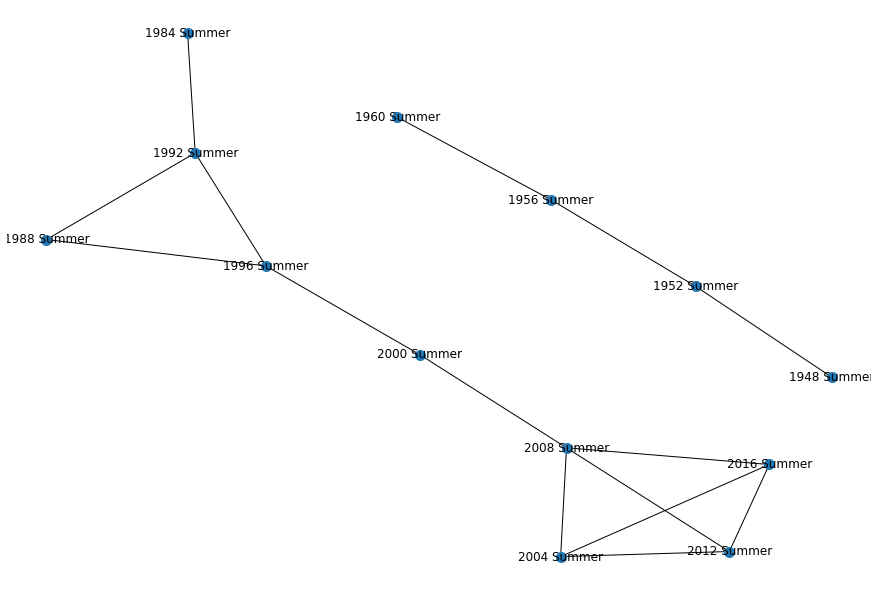

In [ ]:
nx.draw(G, pos=nx.kamada_kawai_layout(G), node_size=100, with_labels=True)